<a href="https://colab.research.google.com/github/DataScientistTX/PyTorch_Projects/blob/main/PyTorch_class_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda")

<ipython-input-1-08ec15666028>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
<ipython-input-1-08ec15666028>:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [2]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [3]:
def visualize2DSoftmax(X, y, model, title=None):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

In [4]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    #At the start of this function,
    #we need to allocate space to store results such as the losses,
    #predictions, and the time we start computing:

    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()

    # The training loop looks almost identical to the one we have used so far.
    # The only thing we need to change is whether we use the optimizer.
    # We can check this by looking at the model.training flag,
    # which is True if our model is in training mode (model = model.train())
    # or False if it’s in evaluation/inference mode (model = model.eval()).
    # We can wrap the backward() call on the loss and optimizer calls into an if statement
    # at the end of each loop:

    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        # Finally, we need to store the labels and predictions y_hat into y_true and y_pred,
        # respectively.
        # This can be done by calling .detach().cpu().numpy() to convert both from PyTorch tensors
        # into NumPy arrays.
        # Then we simply extend the lists of all labels by the current labels we are processing:

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()

            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())

    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

In [5]:
def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    # the ability to save a simple checkpoint of the most recently completed epoch.
    # In PyTorch, the torch.load and torch.save functions can be used for this purpose.
    # While there is more than one way to use these methods, we recommend using the
    # dictionary-style approach shown here,
    # which lets us save the model, the optimizer state, and other information,
    # all in one object:


    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [6]:
X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

In [7]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_pd = train_simple_network(model, loss_func, training_loader,
                                  epochs=5, test_loader=testing_loader,
                                  checkpoint_file='model.pt',
                                  score_funcs={'Acc':accuracy_score,'F1': f1_score})

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Time to look at some results. First, let’s see that we can load our checkpoint model rather than use the one we already trained. To load a model, we first need to define a new model that has all the same sub-modules as the original, and they all need to be the same size. This is necessary so the weights all match up. If we saved a model with 30 neurons in the second hidden layer, we need to have a new model with 30 neurons; otherwise, there will be too few or too many, and an error will occur.

One reason we use the torch.load and torch.save functions is the map_location argument that they provide. This handles loading a model from the data to the cor- rect compute device for us. Once we load in the dictionary of results, we can use the load_state_dict function to restore the states of our original model into this new object. Then we can apply the model to the data and see that we get the same results:

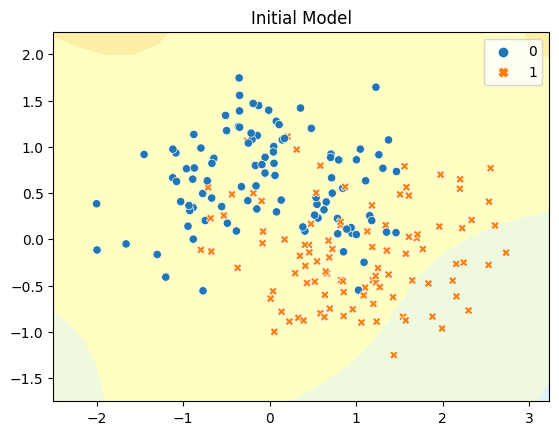

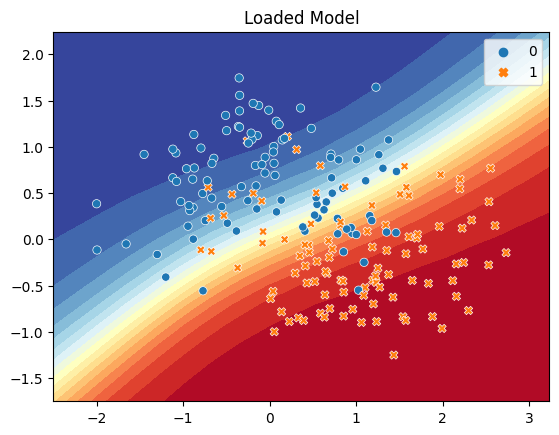

In [8]:
model_new = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)

# Model_new is not yet trained, resuls are random
visualize2DSoftmax(X_test, y_test, model_new, title="Initial Model")
plt.show()

# The previously trained model with 20 epochs above it the one we are loading as model.pt
checkpoint_dict = torch.load('model.pt', map_location=device)
model_new.load_state_dict(checkpoint_dict['model_state_dict'])
visualize2DSoftmax(X_test, y_test, model_new, title="Loaded Model")
plt.show()

You can easily see that the initial model does not give very good predictions because its weights are random values and untrained. If you run the code several times, you should see many slightly different but equally unhelpful results. But after we load the previous model state into the model_new, we get the nice crisp results we expect.

Our new training function was written to return a pandas DataFrame object with infor- mation about the model after every epoch. This gives us some valuable information that we can easily visualize. For example, we can quickly plot the training and validation accuracy as a function of the finished epoch:

<Axes: xlabel='epoch', ylabel='train Acc'>

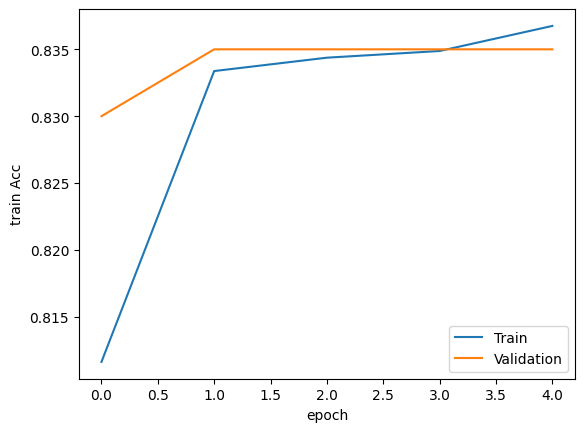

In [9]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='epoch', y='test Acc', data=results_pd, label='Validation')

It’s now easy to see that by using more data, it took about two epochs for our model to top out on the noisier training data. Two score functions were provided, so let’s look at the F1 score as a function of the literal amount of training time in seconds. This will become more useful in the future if we want to compare how quickly two different models can learn:


<Axes: xlabel='total time', ylabel='train F1'>

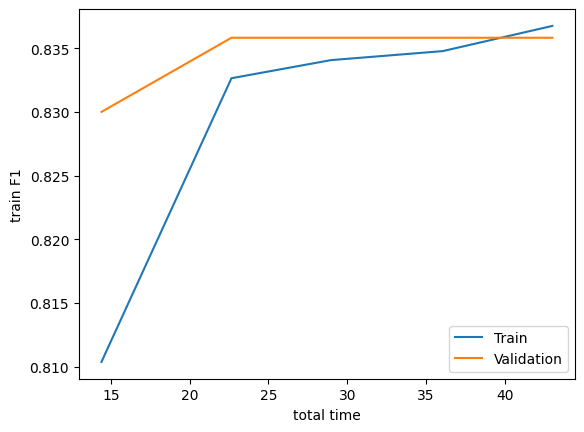

In [10]:
sns.lineplot(x='total time', y='train F1', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test F1', data=results_pd, label='Validation')

TRAINING IN BATCHES

DataLoader has functionality built in with the optional batch_size argument. If a value is unspecified, it defaults to batch_size=1. If we set this to batch_size=len(train_dataset), we perform true gradient descent:


In [11]:
training_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
model_gd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_true_gd = train_simple_network(model_gd, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Five epochs of training just happened in 0.536 seconds. Clearly, training on more data at one time has allowed us to benefit from the parallelism available in a modern GPU. But if we plot the accuracy, we see that training the gradient descent (B = N ) has produced a less accurate model:


<Axes: xlabel='total time', ylabel='test Acc'>

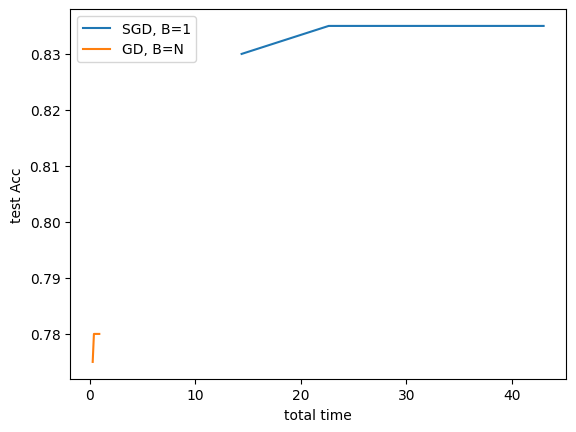

In [12]:
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='test Acc', data=results_true_gd, label='GD, B=N')

When we use SGD, we perform N updates per epoch, so we get more updates or steps for a fixed number of epochs. But because of the stochastic or random behavior of using just one data point for each update, the steps we take are noisy. They don’t always head in the correct direction. The larger total number of steps eventually gets us closer to the answer, but the cost is an increase in runtime because we lose the computational efficiency of processing all the data at once.

The solution we use in practice is to balance between these two extremes. Let’s choose a batch size big enough to use the GPU more efficiently but small enough that we still get to perform many more updates per epoch. We use B to denote the batch size; for most applications, you will find B ∈ [32, 256] is a good choice. Another good rule of thumb is to make the batch size as large as you can fit into GPU memory and to add more training epochs until the model converges. This requires a bit more work because as you develop your network and make changes, the largest batch size you can fit onto your GPU may change.

In [13]:
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model_sgd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_batched = train_simple_network(model_sgd, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Now, if we plot the results as a function of time, we see the green line giving us the best of both worlds. It runs in only 1.044 seconds and gets nearly the same accuracy. You will find that using batches of data like this has almost no downside and is the preferred approach in modern deep learning.

<Axes: xlabel='total time', ylabel='test Acc'>

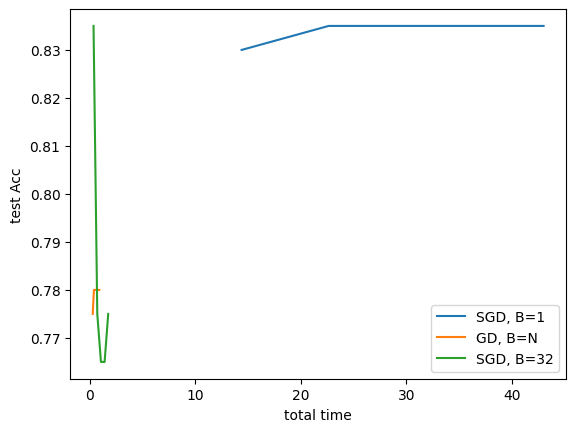

In [14]:
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='test Acc', data=results_true_gd, label='GD, B=N')
sns.lineplot(x='total time', y='test Acc', data=results_batched, label='SGD, B=32')

NOTE Because we only use the validation data to evaluate how our model is doing and not to update the weights of the model, the batch size used to validate the data has no particular tradeoff. We can just increase the batch size to whatever runs fastest and go with that. The results will be the same regardless of the batch size used for the test data. In practice, most people use the same batch size for training and testing data for simplicity.
